# Barrier

In [1]:
from matplotlib.colors import Normalize
from time import time

# Substrate
from tool_create_substrate import calc_matrices_bvect
from tool_create_substrate import particle_en_gaussian, calc_en_gaussian
from tool_create_substrate import substrate_from_params

# Cluster
from tool_create_cluster import rotate, cluster_from_params

# Energy landcape as a function of translation
from static_trasl_map import static_traslmap
# Energy landcape as a function of rotation
from static_roto_map import static_rotomap
# Energy landcape as a function of roto-translation
from static_rototrasl_map import static_rototraslmap
# Relax a string in between two point
from static_barrier_string import static_barrier

# Misc
from tool_create_substrate import gaussian, get_ks
from misc import get_brillouin_zone_2d, plot_BZ2d, plot_UC, plt_cosmetic

## Substrate

In [2]:
rho = 1+1/20 # Mismatch. Put 1 to test commensurate. (cluster lattice spacing if substrate spacing fixed to 1). 
params = {
    # --- SUBSTRATE ---
    'sub_basis': [[0,0]],
    'b1': [1,0],
    'b2': [-1/2, sqrt(3)/2],
    'epsilon': 1,
    'well_shape': 'gaussian',
    'sigma': 0.1, 'a': 0.3, 'b': 0.45,
    # --- CLUSTER ---
    'a1': rho*np.array([1,0]), 'a2': rho*np.array([1/2,-sqrt(3)/2]), # triangular lattice
    'cl_basis': [[0,0]], # no basis
    'cluster_shape': 'circle',
    'N1': 25, 'N2': 25,
    'theta': 0.90909, 'pos_cm': [0, 0.581] 
}

R = max([np.linalg.norm([b for b in [params['b1'], params['b2']]])])
u, u_inv = calc_matrices_bvect(params['b1'], params['b2'])
S = u_inv.T # Lattice matrix

pen_func, en_func, en_inputs = substrate_from_params(params)

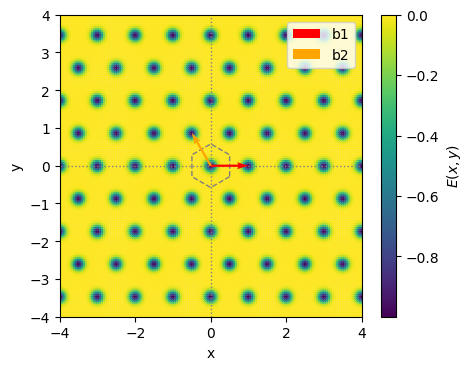

In [3]:
x0, x1, nx = -4, 4, 150
y0, y1, ny = -4, 4, 150
xx, yy = np.meshgrid(np.linspace(x0, x1, nx), np.linspace(y0, y1, ny))
pp = np.stack([xx, yy], axis=2)
p = np.reshape(pp, (pp.shape[0]*pp.shape[1], 2))

en, F, tau = pen_func(p, [0,0], *en_inputs)

fig, axE = plt.subplots(1,1, dpi=100, sharex=True, sharey=True, figsize=(5,4))
# fig.suptitle(title)
plt_params = {'ls': '--', 'color': 'tab:gray', 'lw': 1, 'fill': False}
s0 = 1

# Energy
sc = axE.scatter(p[:,0], p[:,1], c=en, s=s0)
plt.colorbar(sc, label=r'$E(x,y)$', ax=axE)
if params['well_shape'] != 'Sin': plot_BZ2d(axE, get_brillouin_zone_2d(S),plt_params)
axE.quiver(0, 0, *S[0], angles='xy', scale_units='xy', scale=1, zorder=5, color='red', label='b1')
axE.quiver(0, 0, *S[1], angles='xy', scale_units='xy', scale=1, zorder=5, color='orange', label='b2')
axE.legend(loc='upper right')
axE.set_xlim([x0, x1])
axE.set_ylim([y0, y1])
axE.set_ylabel('y')
axE.set_aspect('equal')
plt_cosmetic(axE)
plt.show()


## Cluster

Cluster circle of size N=571


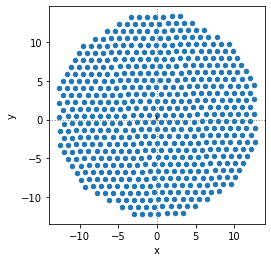

In [4]:
# Create the cluster
pos = cluster_from_params(params)
N = pos.shape[0] # store the number of particles
print("Cluster %s of size N=%i" % (params['cluster_shape'], N))

# It's more convenient to return a cluster in the origin, then shift and rotate outside of the function
pos = rotate(pos, params['theta']) + params['pos_cm']

plt.scatter(pos[:,0], pos[:,1], s=20)
plt.quiver(0,0, *params['pos_cm'], angles='xy', scale_units='xy', scale=1)
plt_cosmetic(plt.gca())
plt.show()

### quickly color it for energy

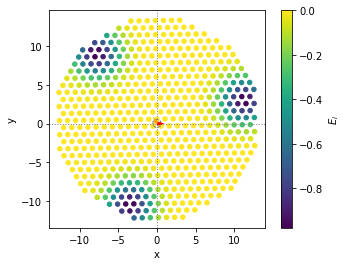

In [5]:
# Create the cluster
pen, pF, ptau = pen_func(pos, params['pos_cm'], *en_inputs)

axE = plt.gca()
plt_params = {'ls': '--', 'color': 'tab:gray', 'lw': 1, 'fill': False}
s0 = 20

sc = axE.scatter(pos[:,0], pos[:,1], c=pen, s=s0)
plt.colorbar(sc, label=r'$E_i$', ax=axE)

if params['well_shape'] != 'Sin': plot_BZ2d(axE, get_brillouin_zone_2d(S),plt_params)
axE.quiver(0, 0, *S[0], angles='xy', scale_units='xy', scale=1, zorder=5, color='red', label='b1')
axE.quiver(0, 0, *S[1], angles='xy', scale_units='xy', scale=1, zorder=5, color='orange', label='b2')

axE.set_ylabel('y')
axE.set_aspect('equal')
plt_cosmetic(axE)
plt.show()

## Translation landscape

In [6]:
t0 = time()
tdata = static_traslmap(pos, {"da11": -1.5, "da12": 1.5, 
                             "da21": -1.5, "da22": 1.5,
                             "nbin": 200,
                             'S': S, 'en_params': en_inputs}, 
                       en_func, log_propagate=True)
te = time()-t0
print('Done %is %.2fmin' % (te, te/60))

# Separate the output data into components 
pp = tdata[:,:2]
enmap = tdata[:,2]
Fmap = tdata[:,3:5]
taumap = tdata[:,5]

NameError: name 't00' is not defined

## Barrier

In [ ]:
t0 = time()
data, L, V = static_barrier(pos, {"p0": [0,0], "p1": [0.7,-0.5],
                                  "Nsteps": 3000, "Npt": 50,
                                  'S': S, 'en_params': en_inputs}, 
                            en_func, log_propagate=False, debug=True)

tee = time()-t00
print('Done %is %.2fmin' % (tee, tee/60))

In [ ]:
fig, (axE, axpath) = plt.subplots(1,2, dpi=200, sharex=False, sharey=False, figsize=(6,3))
plt_params = {'ls': '--', 'color': 'tab:gray', 'lw': 1, 'fill': False}
s0 = 0.8 # Size of points
marker = 's'
# Plot limits
x0, x1 = -0.7, 1.1
y0, y1 = -0.8, 0.9


# Energy
# norm = Normalize(-N,0)
norm = None
xx = np.reshape(pp[:,0], (int(np.sqrt(pp.shape[0])),int(np.sqrt(pp.shape[0]))))
yy = np.reshape(pp[:,1], (int(np.sqrt(pp.shape[0])),int(np.sqrt(pp.shape[0]))))
zz = np.reshape(enmap, (int(np.sqrt(pp.shape[0])),int(np.sqrt(pp.shape[0]))))
sc = axE.contourf(xx, yy, zz, levels=10, cmap='RdYlBu_r', alpha=0.1)
sc = axE.contour(xx, yy, zz, levels=10, cmap='RdYlBu_r', linewidths=0.5, alpha=1)
#plt.colorbar(sc, label=r'$E(x,y)$', ax=axE)
if params['well_shape'] != 'Sin': plot_BZ2d(axE, get_brillouin_zone_2d(S), plt_params)
axE.quiver(0, 0, *S[0], angles='xy', scale_units='xy', scale=1, zorder=5, color='red', label=r' b1')
axE.quiver(0, 0, *S[1], angles='xy', scale_units='xy', scale=1, zorder=5, color='orange', label=r' b2')

# Path
axE.plot(data[:,0], data[:,1], '-k', lw=0.5, zorder=1)
axE.scatter(data[:,0], data[:,1], c=data[:,2], cmap='magma', s=2, zorder=2)

axE.set_xlim([x0, x1])
axE.set_ylim([y0, y1])
plt_cosmetic(axE)
axE.set_ylabel(r'$y_\mathrm{cm}$')
axE.set_xlabel('')

axpath.plot(np.linspace(0, 1, data.shape[0]), data[:,2])
axpath.scatter(np.linspace(0, 1, data.shape[0]), data[:,2], c=data[:,2], cmap='magma', s=20, zorder=2)
axpath.set_xlabel(r'path')
axpath.set_ylabel(r'energy')

plt.tight_layout()
plt.show()

#### Force along the path

In [ ]:
fig, (axE, axpath) = plt.subplots(1,2, dpi=200, sharex=False, sharey=False, figsize=(6,3))

Fpath = np.linalg.norm(data[:,3:5], axis=1)

# FORCE
sc = axE.contour(xx, yy, zz, levels=10, cmap='RdYlBu_r', linewidths=0.5, alpha=1)
axE.plot(data[:,0], data[:,1], '-k', lw=0.5, zorder=1)
#plt.scatter(data[:,0], data[:,1], c=data[:,2], cmap='magma', s=20, zorder=2)
axE.quiver(data[:,0], data[:,1], data[:,3], data[:,4], Fpath,
           angles='xy', scale_units='xy', scale=1e3, 
           zorder=2, cmap='viridis'
)
plt_cosmetic(axE)
axE.set_xlim([-0.05,0.55])
axE.set_ylim([-0.4,0.05])

# PATH
#axt = axpath.twinx()
#axt.plot(np.linspace(0, 1, data.shape[0]), data[:,2], '--')

axpath.plot(np.linspace(0, 1, data.shape[0]), Fpath)
axpath.scatter(np.linspace(0, 1, data.shape[0]), Fpath, 
               c=np.linalg.norm(data[:,3:5], axis=1), cmap='viridis', s=20, zorder=2)
axpath.set_xlabel(r'path')
axpath.set_ylabel(r'force')
print('Static friction Fs=%.5g' % np.max(Fpath))

plt.tight_layout()
plt.show()